## Import libraries

In [46]:
from lib.data.raw import load_dataset
from lib.data import constants

import lib.visualization as viz

from geopy import distance

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

## Download measuring stations data

In [5]:
# download data from https://datos.madrid.es/egob/

stations = []

for dataset_name in constants.MEASURING_STATIONS_DATA_NAMES:
    data_it = load_dataset(dataset_name, 'csv', 2022, verbose=True) # iterator
    stations.append(next(data_it))

traffic_stations, air_stations, weather_stations, noise_stations = stations


traffic_stations = traffic_stations[['id', 'tipo_elem', 'longitud', 'latitud']]

air_stations = air_stations[['CODIGO_CORTO', 'LONGITUD', 'LATITUD']]
air_stations = air_stations.rename(columns={
    'CODIGO_CORTO': 'id',
    'LONGITUD': 'longitud',
    'LATITUD': 'latitud'
})

weather_stations = weather_stations[['CÓDIGO_CORTO', 'LONGITUD', 'LATITUD']]
weather_stations = weather_stations.rename(columns={
    'CÓDIGO_CORTO': 'id',
    'LONGITUD': 'longitud',
    'LATITUD': 'latitud'
})

noise_stations = noise_stations[['Nº', 'LONGITUD_WGS84', 'LATITUD_WGS84']]
noise_stations = noise_stations.rename(columns={
    'Nº': 'id',
    'LONGITUD_WGS84': 'longitud',
    'LATITUD_WGS84': 'latitud'
})

# 3-4s

  Found 48 files
    Dataframe size: (4663, 9)
  Found 1 files
    Dataframe size: (24, 25)
  Found 1 files
    Dataframe size: (36, 24)
  Found 1 files
    Dataframe size: (31, 17)


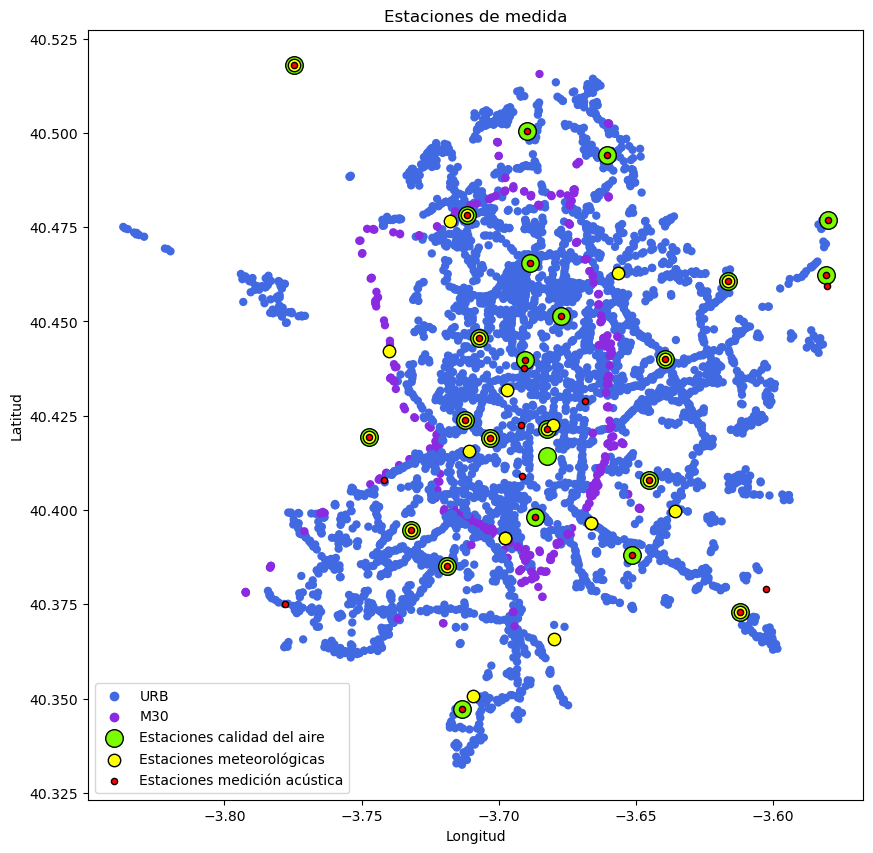

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax = sns.scatterplot(x="longitud", y="latitud",
                     hue="tipo_elem",
                     linewidth=0,
                     palette={'URB': 'royalblue', 'M30': 'blueviolet'},
                     data=traffic_stations)

air_stations.plot.scatter(x='longitud', y='latitud', c='lawngreen', s=160, ax=ax, edgecolors='black', label='Estaciones calidad del aire')

weather_stations.plot.scatter(x='longitud', y='latitud', c='yellow', s=80, ax=ax, edgecolors='black', label='Estaciones meteorológicas')

noise_stations.plot.scatter(x='longitud', y='latitud', c='red', ax=ax, edgecolors='black', label='Estaciones medición acústica')

plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.legend(loc='best')
plt.title('Estaciones de medida')

plt.show()

## Choose those stations that can meassure air quality, noise and weather data

In [15]:
common_stations = pd.merge(air_stations, weather_stations, on=['longitud', 'latitud'], suffixes=('_air', '_weather'))\
                    .merge(noise_stations, on=['longitud', 'latitud'])\
                    .rename(columns={'id': 'id_noise'})

common_stations['id_weather'] = common_stations['id_weather'].astype(int)

common_stations = common_stations.reset_index().rename(columns={'index': 'id'})

common_stations = common_stations[['id', 'longitud', 'latitud', 'id_air', 'id_weather', 'id_noise']]

common_stations

,id,longitud,latitud,id_air,id_weather,id_noise
0,0,-3.712257,40.423882,4,4,4
1,1,-3.682316,40.421553,8,8,8
2,2,-3.639242,40.440046,16,16,16
3,3,-3.731836,40.394782,18,18,18
4,4,-3.747345,40.419358,24,24,24
5,5,-3.703166,40.419209,35,35,3
6,6,-3.645310,40.407952,36,36,20
7,7,-3.707130,40.445544,38,38,10
8,8,-3.711536,40.478232,39,39,5
9,9,-3.612139,40.373012,54,54,54


In [16]:
from geopy import distance

calculate_distance = lambda long_1, lat_1, long_2, lat_2: distance.distance((lat_1, long_1), (lat_2, long_2)).km # geodesic distance between points

def closest_meassure_station(long, lat):
    distances = np.vectorize(calculate_distance)(common_stations['longitud'], common_stations['latitud'], long, lat)
    min_idx = np.argmin(distances)

    return distances[min_idx], min_idx, common_stations.iloc[min_idx, 1], common_stations.iloc[min_idx, 2]


traffic_stations_dist = traffic_stations.copy(deep=True)

traffic_stations_dist['distance'], \
    traffic_stations_dist['closest_id'], \
        traffic_stations_dist['closest_long'], \
            traffic_stations_dist['closest_lat'] = np.vectorize(closest_meassure_station)(traffic_stations_dist['longitud'], traffic_stations_dist['latitud'])
# 10-11s

traffic_stations_dist

,id,tipo_elem,longitud,latitud,distance,closest_id,closest_long,closest_lat
0,3840,URB,-3.688323,40.430502,1.116819,1,-3.682316,40.421553
1,3841,URB,-3.687256,40.430524,1.080753,1,-3.682316,40.421553
2,3842,URB,-3.691727,40.422132,0.801260,1,-3.682316,40.421553
3,3843,URB,-3.691929,40.421433,0.815929,1,-3.682316,40.421553
4,3844,URB,-3.688470,40.433782,1.454867,1,-3.682316,40.421553
...,...,...,...,...,...,...,...,...
4658,6809,M30,-3.659954,40.483080,4.406790,8,-3.711536,40.478232
4659,6810,M30,-3.659926,40.483158,4.410215,8,-3.711536,40.478232
4660,6933,M30,-3.672497,40.484118,3.374157,8,-3.711536,40.478232
4661,7129,M30,-3.672500,40.484181,3.375266,8,-3.711536,40.478232


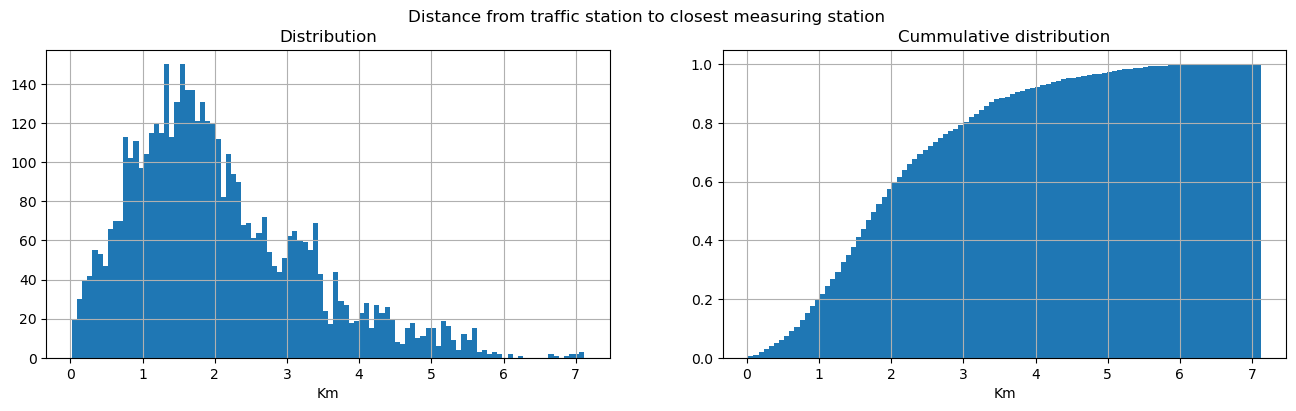

In [55]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

plt.subplot(121)
traffic_stations_dist['distance'].hist(bins=100)
plt.xlabel('Km')
plt.title('Distribution')

plt.subplot(122)
traffic_stations_dist['distance'].hist(bins=100, density=True, cumulative=True, ax=ax[1])
plt.xlabel('Km')
plt.title('Cummulative distribution')

fig.suptitle('Distance from traffic station to closest measuring station')

plt.show()

In [28]:
traffic_stations_closest = traffic_stations_dist[(traffic_stations_dist['distance'] < 1) & (traffic_stations_dist['tipo_elem'] != 'M30')]

print(traffic_stations_closest.shape)

(860, 8)


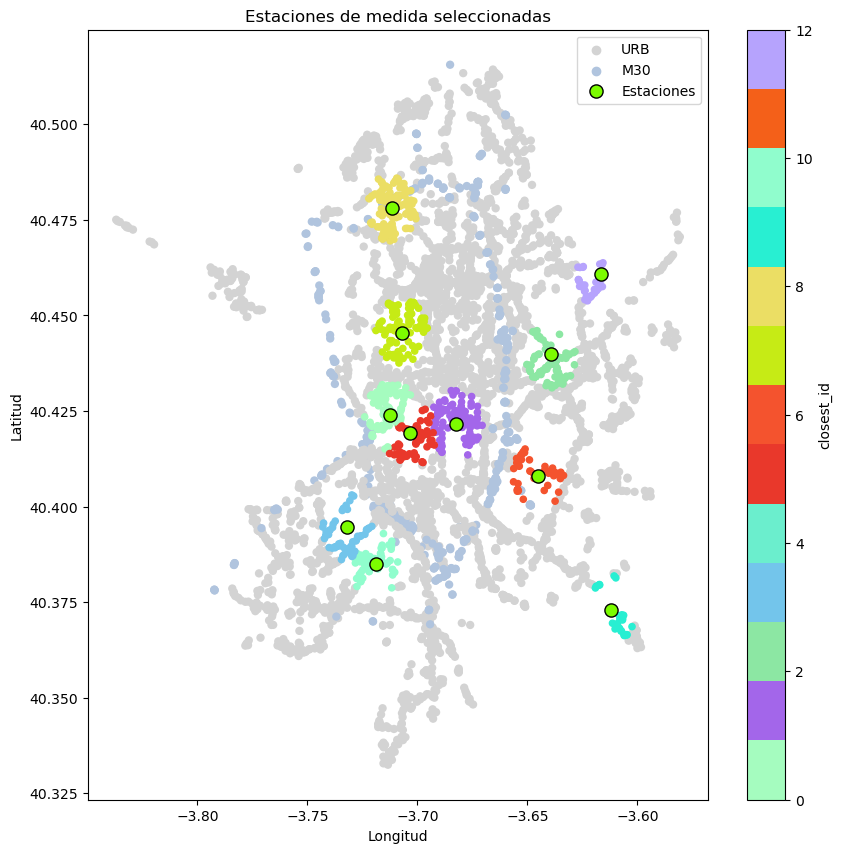

In [31]:
cmap = viz.rand_cmap(common_stations.shape[0], type='bright', first_color_black=False, last_color_black=False, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

traffic_stations_discarded = traffic_stations_dist[(traffic_stations_dist['distance'] >= 1) | (traffic_stations_dist['tipo_elem'] == 'M30')]

ax = sns.scatterplot(x="longitud", y="latitud",
                     hue="tipo_elem",
                     linewidth=0,
                     palette={'URB': 'lightgrey', 'M30': 'lightsteelblue'},
                     data=traffic_stations_discarded)

traffic_stations_closest.plot.scatter(x='longitud', y='latitud', c='closest_id', colormap=cmap, figsize=(10,10), ax=ax)


common_stations_closest = common_stations[common_stations['id'].isin(traffic_stations_closest['closest_id'])]
common_stations_closest.plot.scatter(x='longitud', y='latitud', c='lawngreen', s=90, ax=ax, edgecolors='black', label='Estaciones')

plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.legend(loc='best')
plt.title('Estaciones de medida seleccionadas')

plt.show()

## Save only selected measuring stations

In [54]:
id_cols = ['id_air', 'id_weather', 'id_noise']
save_names = ['air_quality', 'weather', 'noise']

if not os.path.exists(constants.SAVE_DIR):
    os.mkdir(constants.SAVE_DIR)

for id_col, name in zip(id_cols, save_names):
    filtered_stations_data = common_stations_closest[[id_col, 'longitud', 'latitud', 'id']]

    filtered_stations_data = filtered_stations_data.rename(columns={
        'id': 'common_id',
        id_col: 'id'
    })

    filtered_stations_data.to_csv(f'{constants.SAVE_DIR}{name}_measuring_stations.csv', index=False)

traffic_stations_closest[['id', 'longitud', 'latitud', 'closest_id']]\
    .rename(columns={'closest_id': 'common_id'})\
        .to_csv(f'{constants.SAVE_DIR}traffic_measuring_stations.csv', index=False)